In [899]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

I. Предобработка данных
=
## 1. Внешний вид 

In [900]:
df = pd.read_csv('/kaggle/input/medics-yandex/medics_1.csv', sep=',', skipinitialspace=True, decimal=',')
df.columns = [col.lower().replace(',', '').replace('.', '').replace(" ", '_') for col in df.columns]

df.head(7)

,развитие_опп,хбп,возраст,пол,гб,сахарный_диабет,стенокардия,инфаркт_миокарда,мерцательная_аритмия,желудочковая_экстрасистолия,...,толщина_паренхимы_почек,аик,количество_шунтов,длительность_операции,длительность_аик,время_пережатия_аорты,объем_кровопотерии,объем_гемотрансфузии,объем_инфузий,диурез
0,нет,Стадия C1-C2,67,1,1,1,1,1,0,0,...,14.0,0,1,150,0,0,200,830,2900,900
1,есть,Стадия C1-C2,69,1,1,0,1,0,0,0,...,15.0,1,4,235,143,121,600,640,900,800
2,нет,Пациенты без ХБП,50,1,1,0,1,1,0,0,...,17.0,0,1,210,0,0,250,0,1800,500
3,нет,Стадия C1-C2,62,1,1,0,1,1,1,0,...,16.0,1,3,210,71,43,500,1283,1700,1700
4,есть,Стадия C1-C2,55,1,1,1,1,1,0,0,...,15.0,1,3,265,116,74,500,1560,1800,1300
5,нет,Пациенты без ХБП,60,1,1,0,1,1,0,1,...,19.0,1,3,240,74,62,200,1350,2100,1800
6,есть,Стадия C1-C2,65,1,1,1,1,0,0,0,...,15.0,1,3,185,94,59,500,600,400,2000


Названия колонок отформатированы, пропусков много. 


In [901]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 67 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   развитие_опп                 200 non-null    object 
 1   хбп                          200 non-null    object 
 2   возраст                      200 non-null    int64  
 3   пол                          200 non-null    int64  
 4   гб                           200 non-null    int64  
 5   сахарный_диабет              200 non-null    int64  
 6   стенокардия                  200 non-null    int64  
 7   инфаркт_миокарда             200 non-null    int64  
 8   мерцательная_аритмия         200 non-null    int64  
 9   желудочковая_экстрасистолия  200 non-null    int64  
 10  а-в_блокада                  200 non-null    int64  
 11  блокада_ножек_пучка_гиса     200 non-null    int64  
 12  сад                          200 non-null    int64  
 13  дад                 

## Дублирование

In [902]:
df.duplicated().sum()

1

In [903]:
df.drop_duplicates(inplace=True)

Возможная причина дубликата: данные об одном пациенте вносились в медицинскую базу данных повторно.

## 2. Пропуски, выбросы

**Добавим новую бинарную колонку "Есть_ли_пропуски"**  
          -1 - есть пропуск хотя бы в одной колонке.  
          - 0 - все данные есть.  
Заменять же пропуски будем по ходу работы с каждой колонкой отдельно. 

In [904]:
df['есть_ли_пропуски'] = df.isnull().any(axis=1).astype(int)
df.head()

,развитие_опп,хбп,возраст,пол,гб,сахарный_диабет,стенокардия,инфаркт_миокарда,мерцательная_аритмия,желудочковая_экстрасистолия,...,аик,количество_шунтов,длительность_операции,длительность_аик,время_пережатия_аорты,объем_кровопотерии,объем_гемотрансфузии,объем_инфузий,диурез,есть_ли_пропуски
0,нет,Стадия C1-C2,67,1,1,1,1,1,0,0,...,0,1,150,0,0,200,830,2900,900,0
1,есть,Стадия C1-C2,69,1,1,0,1,0,0,0,...,1,4,235,143,121,600,640,900,800,1
2,нет,Пациенты без ХБП,50,1,1,0,1,1,0,0,...,0,1,210,0,0,250,0,1800,500,1
3,нет,Стадия C1-C2,62,1,1,0,1,1,1,0,...,1,3,210,71,43,500,1283,1700,1700,0
4,есть,Стадия C1-C2,55,1,1,1,1,1,0,0,...,1,3,265,116,74,500,1560,1800,1300,0


***

In [905]:
def graph_histplot_bin(dd, factor):  # Исследование количественных шкал, построение гистограммы и ящика с усами
    sns.set(style='white')
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    sns.histplot(dd[factor], bins=20, kde=True, ax=ax[0]) 
    sns.boxplot(data=dd, y=factor, ax=ax[1], color="pink")
    
    ax[0].axvline(np.mean(dd[factor]),color='r', linestyle='-', label='Среднее')
    ax[0].axvline(np.median(dd[factor]),color='b', linestyle='--', label='Медиана')
    
    ax[0].set_xlabel(factor.capitalize(), size=13)
    ax[0].set_ylabel('')
    ax[1].set_xlabel('')
    
    ax[0].legend(loc='center right')
    
    #plt.suptitle(f'Исследование данных на нормальность шкалы {factor}', size=12, y=1.01)
    plt.show()

In [906]:
df['мочевина_'].isna().sum()

1

Всего один пропуск, скорее всего он случайный.

In [907]:
df[df['мочевина_'].isnull()]

,развитие_опп,хбп,возраст,пол,гб,сахарный_диабет,стенокардия,инфаркт_миокарда,мерцательная_аритмия,желудочковая_экстрасистолия,...,аик,количество_шунтов,длительность_операции,длительность_аик,время_пережатия_аорты,объем_кровопотерии,объем_гемотрансфузии,объем_инфузий,диурез,есть_ли_пропуски
93,нет,Пациенты без ХБП,53,1,0,0,1,1,1,0,...,1,2,200,95,44,500,920,1600,3200,1


**Для дальнейшего удобства работы с данными, введем новую колонку "Возрастная_группа"**
  - 18-30 - "до 30"
  - 31-40 - "от 31 до 40"
  - ...
  - 61-70 "от 61 до 70"
  - 71+ "от 71"

In [908]:
def determine_age(x):
    if x <= 30:
        return "до 30"
    elif 30 < x <= 40:
        return "от 31 до 40"
    elif 41 <= x <= 50:
        return "от 41 до 50"
    elif 51 <= x <= 60:
        return "от 51 до 60"
    elif 61 <= x <= 70:
        return "от 61 до 70"
    else:
        return "от 70"

df['возрастная_группа'] = df['возраст'].apply(lambda x: determine_age(x))
df.head()

,развитие_опп,хбп,возраст,пол,гб,сахарный_диабет,стенокардия,инфаркт_миокарда,мерцательная_аритмия,желудочковая_экстрасистолия,...,количество_шунтов,длительность_операции,длительность_аик,время_пережатия_аорты,объем_кровопотерии,объем_гемотрансфузии,объем_инфузий,диурез,есть_ли_пропуски,возрастная_группа
0,нет,Стадия C1-C2,67,1,1,1,1,1,0,0,...,1,150,0,0,200,830,2900,900,0,от 61 до 70
1,есть,Стадия C1-C2,69,1,1,0,1,0,0,0,...,4,235,143,121,600,640,900,800,1,от 61 до 70
2,нет,Пациенты без ХБП,50,1,1,0,1,1,0,0,...,1,210,0,0,250,0,1800,500,1,от 41 до 50
3,нет,Стадия C1-C2,62,1,1,0,1,1,1,0,...,3,210,71,43,500,1283,1700,1700,0,от 61 до 70
4,есть,Стадия C1-C2,55,1,1,1,1,1,0,0,...,3,265,116,74,500,1560,1800,1300,0,от 51 до 60


Эту колонку мы создали для удобной группировки данных по возрасту пациента (особой разницы нет, 53 годы пациенту, или 54) 

Заменим пропуск данными, из таблицы, по колонкам, которые непосредственно [связанны с мочевиной в крови](https://gemotest.ru/info/spravochnik/analizy/mochevina-v-krovi/?ysclid=lutxxvppt3776924936).
> На результат анализа влияет возраст, пол, острые и хронические заболевания, беременность.

In [909]:
q = df.groupby(['возрастная_группа', 'пол', 'гб'])['мочевина_'].median()['от 51 до 60'][1][0]
q

5.0

In [910]:
df['мочевина_'].fillna(q, inplace=True)

/tmp/ipykernel_34/2827047614.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['мочевина_'].fillna(q, inplace=True)


***

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


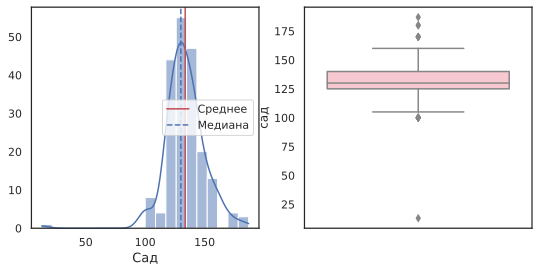

In [911]:
graph_histplot_bin(df, 'сад')

In [912]:
df[df['сад'] < 25]['сад']

0    13
Name: сад, dtype: int64

In [913]:
df[df['сад'] == 13]['дад']

0    80
Name: дад, dtype: int64

Исходя из информации [взятой отсюда](https://zv-clinic.ru/inf/pri-kakom-davlenii-umiraet-chelovek?ysclid=lv15kknkqg117136109), мы можем считать число 13 - выбросом.
>В общем понимании критичное давление у человека (нижняя граница) – 80/60, а снижение до показателей 70/50 может привести к глубокой коме и/или смерти. 

Еще одним аргументом к тому, что это значение САД не корректно является то, что ДАД у пациента = 80. Вообще, ДАД должно быть меньше САД, но в редких случаях может быть наоборот, но разница не может превышать 10-20 миллиметров ртутного столба. ([Источник](https://mag.103.by/topic/61543-menyshe-soli-bolyshe-kalija-chem-v-lyubom-vozraste-opasny-skachki-davlenija-i-chto-s-etim-delaty/))

In [914]:
df[df['сад'] == 13]['возрастная_группа']

0    от 61 до 70
Name: возрастная_группа, dtype: object

In [915]:
df.groupby(['дад', 'возрастная_группа'])['сад'].median()[80]['от 61 до 70']

130.0

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


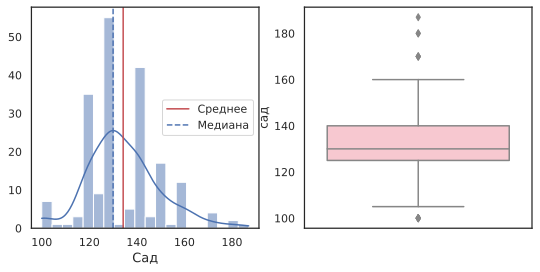

In [916]:
median = df.groupby(['дад', 'возрастная_группа'])['сад'].median()[80]['от 61 до 70']
df['сад'] = df['сад'].apply(lambda x: median if x == 13 else x)
graph_histplot_bin(df, 'сад')

___

In [917]:
df['хлориды'].unique()

array([100. ,   nan, 102. , 103. , 110.7, 100.5, 106. ,  99. , 105.7,
       104. , 109.8, 110. , 101. , 107.8, 107. ,  97. , 109. ,  98. ,
       115.1, 108.9, 108. , 114.4, 100.4, 109.7, 106.5, 102.8, 105. ,
       105.9, 102.4, 116.5, 115. , 104.6, 112. ,  99.8, 108.2, 108.3,
        96. ])

In [918]:
df['хлориды'].isna().sum()

22

В этой колонке уже больше пропусков.

In [919]:
df[df['хлориды'].isnull()].head()

,развитие_опп,хбп,возраст,пол,гб,сахарный_диабет,стенокардия,инфаркт_миокарда,мерцательная_аритмия,желудочковая_экстрасистолия,...,количество_шунтов,длительность_операции,длительность_аик,время_пережатия_аорты,объем_кровопотерии,объем_гемотрансфузии,объем_инфузий,диурез,есть_ли_пропуски,возрастная_группа
1,есть,Стадия C1-C2,69,1,1,0,1,0,0,0,...,4,235,143,121,600,640,900,800,1,от 61 до 70
2,нет,Пациенты без ХБП,50,1,1,0,1,1,0,0,...,1,210,0,0,250,0,1800,500,1,от 41 до 50
6,есть,Стадия C1-C2,65,1,1,1,1,0,0,0,...,3,185,94,59,500,600,400,2000,1,от 61 до 70
13,нет,Пациенты без ХБП,57,1,1,0,1,0,0,1,...,1,150,0,0,400,0,1400,250,1,от 51 до 60
44,есть,Пациенты без ХБП,52,1,1,0,1,0,1,0,...,2,345,167,134,700,602,1600,1000,1,от 51 до 60


In [920]:
df['кальций'].unique()

array([0.99, 1.02, 0.96, 0.94, 0.85, 1.12, 1.22, 1.2 , 0.82, 0.9 , 1.1 ,
        nan, 1.13, 0.88, 1.14, 1.24, 1.01, 1.  , 1.11, 1.16, 0.98, 0.86,
       0.78, 0.79, 2.33, 0.89, 0.83, 0.8 , 0.87, 1.06, 1.05, 1.15, 1.26,
       1.21, 1.07, 0.73, 1.04, 0.72, 1.08, 1.09, 1.03, 0.95, 0.84, 0.71,
       2.4 , 0.7 , 1.6 , 0.75, 1.44, 2.32, 0.93, 1.17])

In [921]:
df['кальций'].isna().sum()

19

Проверим сколько есть пациентов, с пропусками в факторах кальций и хлориды.

In [922]:
query = (df['хлориды'].isnull()) & (df['кальций'].isnull())
a =  df.loc[query]
a

,развитие_опп,хбп,возраст,пол,гб,сахарный_диабет,стенокардия,инфаркт_миокарда,мерцательная_аритмия,желудочковая_экстрасистолия,...,количество_шунтов,длительность_операции,длительность_аик,время_пережатия_аорты,объем_кровопотерии,объем_гемотрансфузии,объем_инфузий,диурез,есть_ли_пропуски,возрастная_группа
13,нет,Пациенты без ХБП,57,1,1,0,1,0,0,1,...,1,150,0,0,400,0,1400,250,1,от 51 до 60
64,есть,Стадия C1-C2,54,1,1,0,1,1,0,0,...,1,245,0,0,250,0,1800,700,1,от 51 до 60
75,есть,Пациенты без ХБП,54,1,1,0,1,1,0,0,...,1,160,0,0,200,0,1700,1000,1,от 51 до 60
87,нет,Пациенты без ХБП,55,1,0,1,1,1,0,0,...,2,260,124,98,500,820,700,1400,1,от 51 до 60
93,нет,Пациенты без ХБП,53,1,0,0,1,1,1,0,...,2,200,95,44,500,920,1600,3200,1,от 51 до 60
104,есть,Пациенты без ХБП,46,0,0,0,1,1,0,0,...,2,170,67,44,500,1320,700,1700,1,от 41 до 50
173,есть,Стадия С3,60,1,1,0,1,1,0,0,...,3,230,79,58,500,1010,1750,3300,1,от 51 до 60
174,нет,Стадия C1-C2,40,1,1,0,1,0,0,0,...,1,170,0,0,250,0,1400,1000,1,от 31 до 40


In [923]:
for i in a.columns:
    if len(a[i].unique()) == 1:
        print(i, a[i].unique())

стенокардия [1]
а-в_блокада [0]
хлориды [nan]
кальций [nan]
есть_ли_пропуски [1]


У всех, у кого нет данных по хлоридам и кальцию есть заболевание стенокардия и не было проведена ав блокада.

> __Стенокардия__ – заболевание, обусловленное несоответствием между потребностью миокарда в кислороде и его доставкой, приводящее к нарушениям функций сердца.  
> __Атриовентрикулярная (АВ) блокада__ – частичное или полное прерывание проведения импульса от предсердий к желудочкам. Наиболее частой причиной является идиопатический фиброз или склероз проводящей системы сердца. Диагноз ставится на основании результатов электрокардиографии

Заполним хлорид и кальций усредненными значениями по факторам возрастная группа и наличию гб.

In [924]:
df['хлориды'] = df['хлориды'].fillna(
    df.groupby(['хсн', 'возрастная_группа'])['хлориды'].transform('median'))

In [925]:
df['кальций'] = df['кальций'].fillna(
    df.groupby(['возрастная_группа', 'хсн'])['кальций'].transform('median'))

In [926]:
df['кальций'].isna().sum(), df['хлориды'].isna().sum()

(0, 0)

***

In [927]:
df['рн'].unique()

array(['7,42', '7,49', '7,37', '7,44', '7,41', '8,35', '7,48', '7,43',
       '7,46', '7,55', '7,4', '7,45', '7,51', '7,47', '7,31', '7,39',
       '7,52', '7,34', '7,35', '7,38', '7,5', '2', '1.88', '2.01', '7,36'],
      dtype=object)

Изменим тип данных на правильный.

In [928]:
df['рн'] = df['рн'].str.replace(",", ".")
df = df.astype({'рн': float})

***

In [929]:
df['оксигем'].unique()

array([ 99. ,  98.8,  96.6,  99.4,  99.6,  98. ,  98.5,  99.9,  99.2,
       146. ,  97.4,  99.3,  99.7,  98.7,  97.8,  98.9,  97.9,  99.8,
        98.3,  98.1,  98.6,  99.5,  97.3,  93.9,  96.7,  97.7,  97. ,
        97.5,  66. ,  95.7,  97.6,  98.2,  96. ,  97.1,  99.1,  94.8,
        95.3,  98.4,  96.9])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


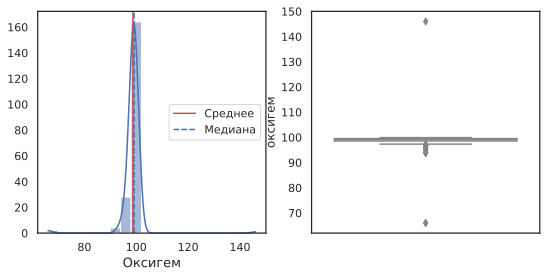

In [930]:
graph_histplot_bin(df, 'оксигем')

**Оксигем** - показатель крови, % (SaO2), проценты не могут быть > 100, изменим на медиану все значения, которые превышают 100

In [931]:
median = df[df['оксигем'] != 140]['оксигем'].median()

df['оксигем'] = df['оксигем'].apply(lambda x: median if x > 100 else x)

***

In [932]:
df['чсс'].unique()

array(['61', '66', '67', '94', '81', '74', '62', '83', '104', '88', '80',
       '91', '84', '77', '50', '119', '70', '79', '75', '68', '98', '73',
       '76', '60', '69', '57', '64', '1000', '58', '59', '7o', '65', '47',
       '54', '55', '56', '72', '41', '78', '46', '105', '82', '51', '52',
       '107', '115', '42', '93', '63', '44', '53', '49', '102'],
      dtype=object)

У фактора ЧСС неправильный тип данных из-за опечатки.

In [933]:
df['чсс'] = df['чсс'].replace('7o', '70')
df = df.astype({'чсс': np.int64})
df['чсс']

0      61
1      66
2      67
3      94
4      81
       ..
195    58
196    53
197    83
198    65
199    70
Name: чсс, Length: 199, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


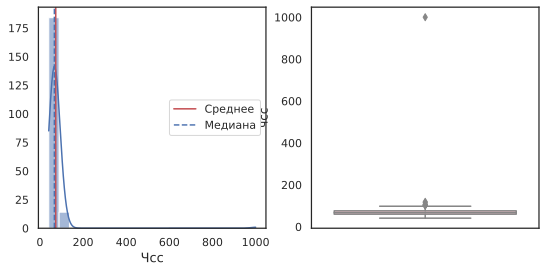

In [934]:
graph_histplot_bin(df, 'чсс')

Заменим на медиану аномальное значение 1000 ударов/минута.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


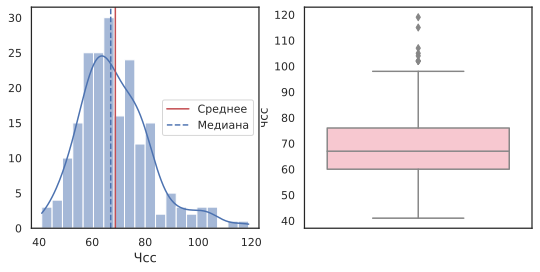

In [935]:
median = df[df['чсс'] != 1000]['чсс'].median()

df['чсс'] = df['чсс'].apply(lambda x: median if x == 1000 else x)

graph_histplot_bin(df, 'чсс')

***

In [936]:
df['мо'].unique()

array([ 6.78,  5.82,  4.26,  6.54,  4.98,  5.1 ,  5.22,  6.18,  5.86,
        5.52,  4.08,  5.34,  6.36,  4.62,  4.74,  5.94,  7.14,  5.28,
        6.12,  5.64,  3.18,  5.16,  8.1 ,  3.84,  7.74,  7.44,  4.86,
        8.58,  8.52,  7.56,  5.46,  4.38,  6.  ,  4.72,  4.68,  4.44,
        5.4 ,  4.2 ,  7.98,  5.76,  7.32,  6.96,  7.02,  6.42,  3.66,
        5.04,  3.96,  3.78,  4.5 ,  7.26,  6.06,  5.58,  4.56,  7.08,
        6.24,  2.34,  4.02,  9.18,  6.84,  8.04, 72.6 ,  6.3 ,  6.66,
        4.8 ])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


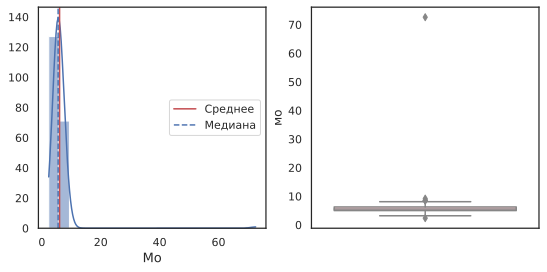

In [937]:
graph_histplot_bin(df, 'мо')

Для того чтобы проверить, является ли число 70 аномальным для минутного обьема сердца, рассмотрим данные о конкретном пациенте, с таким высоким показателем мо.

In [938]:
df.query("мо > 60")

,развитие_опп,хбп,возраст,пол,гб,сахарный_диабет,стенокардия,инфаркт_миокарда,мерцательная_аритмия,желудочковая_экстрасистолия,...,количество_шунтов,длительность_операции,длительность_аик,время_пережатия_аорты,объем_кровопотерии,объем_гемотрансфузии,объем_инфузий,диурез,есть_ли_пропуски,возрастная_группа
167,есть,Пациенты без ХБП,73,1,1,1,1,1,0,1,...,2,200,83,34,450,1440,1500,800,0,от 70


[У минутного объема сердца (МО) есть формула, по которой она рассчитывается.](http://vmede.org/sait/?id=Gospitalnaya_ter_card_storojakova_2008_t1&menu=Gospitalnaya_ter_card_storojakova_2008_t1&page=6&ysclid=lura2nfw6d323379373) Перепроверим, может ли быть МО = 70, посчитав ее по этой формуле.
> "Минутный объем сердца (МО) вычисляют умножением УО на число сердечных сокращений"

In [939]:
mo = np.round((df.query("мо > 60")['уо'] * df.query("мо > 60")['чсс']) / 1000, 2) # /1000 потому что уо в мл, а мо - в литрах
mo[167]

7.38

Таким образом, значение МО = 72.6 - выброс, заменим его вычисленным значением.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


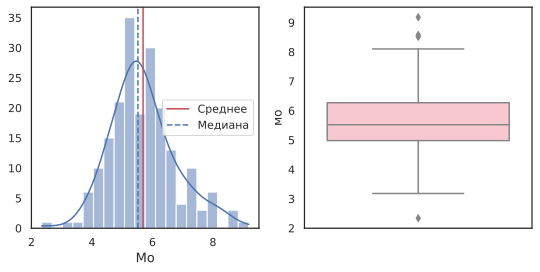

In [940]:
df['мо'] = df['мо'].apply(lambda x: mo[167] if x == 72.6 else x)
graph_histplot_bin(df, 'мо')

***

Ориентируясь на [данный источник](https://medsi-premium.ru/blog/triglitseridy/), выделим факторы, от которых зависит уровень триглицеридов в крови.
> Повышение уровня триглицеридов может быть следствием следующих факторов: 
> - ожирение,
> - сахарный диабет 2 типа и нарушение толерантности к глюкозе,
> - хроническая болезнь почек

In [941]:
df['триглицериды'].fillna(
    df.groupby(['сахарный_диабет', 'хбп'])['триглицериды'].transform('median'), inplace=True)

/tmp/ipykernel_34/2295200904.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['триглицериды'].fillna(


***

In [942]:
df['ачтв'].unique()

array([34. , 31. , 33. , 40. , 29. , 43. , 32. , 35. , 36. , 39. , 38. ,
       52.7, 44. , 55. , 26. , 30. , 48. , 42. , 49. , 37. , 30.9,  nan,
       51. , 25.9, 28. , 45. , 46. , 30.6, 41. ,  0.9, 34.6])

In [943]:
df['ачтв'].fillna(
    df.groupby(['гб', 'стенокардия'])['ачтв'].transform('median'), inplace=True)

/tmp/ipykernel_34/2243726985.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ачтв'].fillna(


***

In [944]:
df['кдр_правого_желудочка'].unique()

array([2.7, 2.6, 3. , 2.2, 2.3, 2.4, 2.5, 2.8, 2.9, 2.1, 3.1, 5.1, 3.3,
       3.2, 1.7, 2. ])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


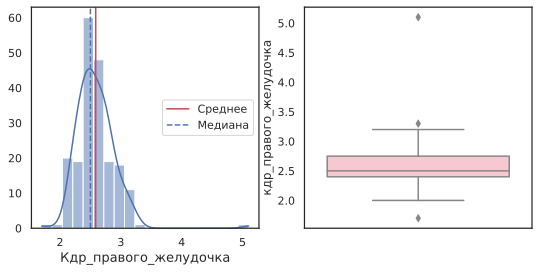

In [945]:
graph_histplot_bin(df, 'кдр_правого_желудочка')

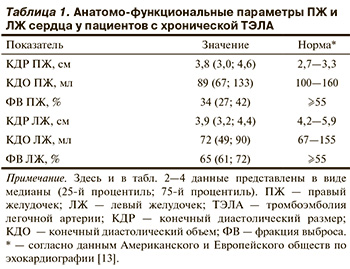

Значение 5 выбросом не является.

***

In [946]:
df['алат'].unique()

array([ 41,  39,  29,  19,  20,  49,  28,  18,  57,  30,  50,  11,  24,
        22,   8,  85,  25,  15,  37,  26,  34,  27,  12,  36,  17,  16,
        21,  88,  23,  10,  14,  35,  31,  44, 144,  72,  40,   7,  38,
        80,  32,  67,  33,  87,  56,  45,  13,  54,  42,  43,  59,  81,
        53,  65,  89,  51])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


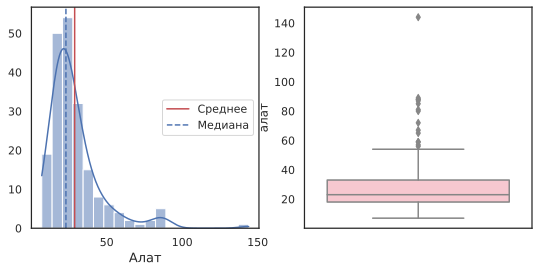

In [947]:
graph_histplot_bin(df, 'алат')

Норма у здорового человека **7—41 МЕ/л**

[Источник.](https://gemotest.ru/info/spravochnik/analizy/alt-alat-alaninaminotransferaza-alanintransaminaza/?ysclid=lusme893gj697663596) 
> В острой стадии заболевания концентрация АЛТ в крови может превышать норму в 10–40 раз. В хронической — в 2–5 раз.

[Подтвердим информацию другим источником:](https://yandex.ru/health/turbo/articles?id=4552&ysclid=lusmn6xb3d591388467)
> Острые вирусные и токсические гепатиты, при которых концентрация АЛТ возрастает в 20 раз и более. В некоторых случаях болезни Боткина увеличение концентрации данного фермента в крови может предшествовать желтушному окрашиванию кожи. При вирусных гепатитах В и С показатель АЛТ может увеличиваться даже в 100 раз, характеризуя при этом токсическое влияние вируса на клетки печени. У лиц с хроническими гепатитами повышение уровня описываемого фермента может служить маркером нового обострения заболевания. Однако в последнем случае АЛТ повышается не более, чем в 3-5 раз. 

Поэтому, хоть показатель 144 и выглядит как выброс, но такой показатель возможен, и показывыет на острую стадию заболевания.

***

Обнаружили еще пропуски.

In [948]:
df['лпнп'] = df['лпнп'].fillna(
    df.groupby(['хсн', 'возрастная_группа'])['лпнп'].transform('median'))
df['лпонп'] = df['лпонп'].fillna(
    df.groupby(['хсн', 'возрастная_группа'])['лпонп'].transform('median'))

***

In [949]:
df['толщина_паренхимы_почек'].unique()

array([14. , 15. , 17. , 16. , 19. ,  nan, 13. , 18. , 11. , 10. , 12. ,
       13.5])

Снова пропуски, заменим на групповую медиану по фактору возрастная группа.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


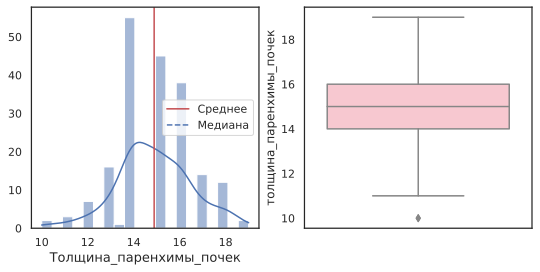

In [950]:
graph_histplot_bin(df, 'толщина_паренхимы_почек')

In [951]:
df['толщина_паренхимы_почек'] = df['толщина_паренхимы_почек'].fillna(
    df.groupby(['возрастная_группа'])['толщина_паренхимы_почек'].transform('median'))

## 3. Аналитический и графический анализ данных 

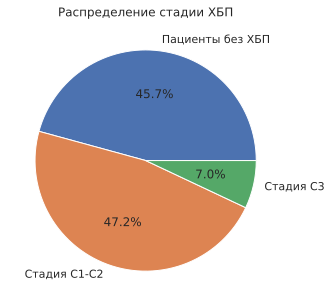

<Figure size 800x500 with 0 Axes>

In [952]:
column = df['хбп'].to_frame().value_counts(normalize=True, sort=False).round(3) * 100
indexs = [i[0] for i in column.index.to_list()]

plt.pie(column, labels=indexs, autopct='%1.1f%%')
plt.title("Распределение стадии ХБП")
plt.figure()
plt.show()

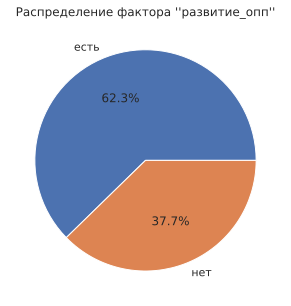

<Figure size 800x500 with 0 Axes>

In [953]:
column = df['развитие_опп'].to_frame().value_counts(normalize=True, sort=False).round(3) * 100
indexs = [i[0] for i in column.index.to_list()]

plt.pie(column, labels=indexs, autopct='%1.1f%%')
plt.title("Распределение фактора ''развитие_опп''")
plt.figure()
plt.show()

Дальше посмотрим, как признаки связаны с целевым фактором.

In [954]:
patients_at_risk  = df.query("развитие_опп == 'есть'").groupby('возрастная_группа').count()['развитие_опп']
patients_at_risk = patients_at_risk.reset_index()

In [955]:
patients_not_at_risk  = df.query("развитие_опп == 'нет'").groupby('возрастная_группа').count()['развитие_опп']
patients_not_at_risk = patients_not_at_risk.reset_index()

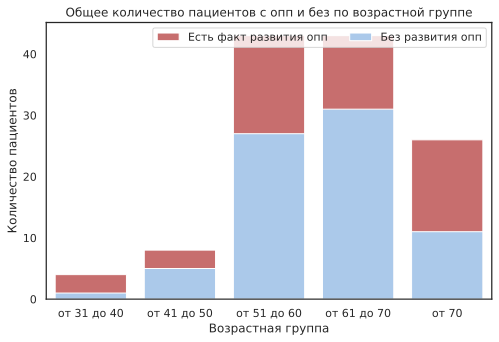

In [956]:
f, ax = plt.subplots()

sns.set_color_codes('muted')
sns.barplot(x='возрастная_группа', y='развитие_опп', data=patients_at_risk,
           label='Есть факт развития опп', color='r'
           ).set_title('Общее количество пациентов с опп и без по возрастной группе')

sns.set_color_codes('pastel')
sns.barplot(x='возрастная_группа', y='развитие_опп', data=patients_not_at_risk,
            label='Без развития опп', color='b')

ax.legend(ncol=2, loc="best", frameon=True)
ax.set(ylabel='Количество пациентов',
       xlabel='Возрастная группа')

plt.show()

Чем старше пациент, тем больше риск дальнейшего развития опп. При этом, в самой младшей группе (от 31 до 40) видно, что у большинства из пациентов (80%) появляется опп. Это связано с тем, что наша выборка небольшая, и делать вывод о том, что люди от 31 до 40 лет чаще подвержены риску развития опп неверно.

Text(0.5, 1.0, 'Взаимосвязь развития опп и наличием диабета')

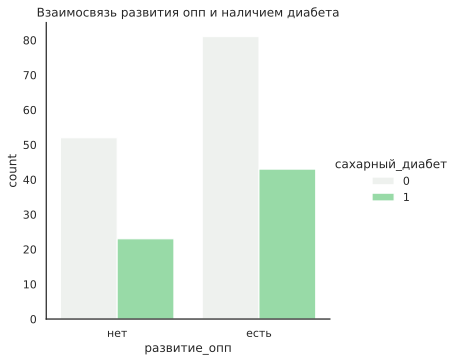

In [957]:
sns.catplot(x = 'развитие_опп', hue = 'сахарный_диабет', data=df, kind = 'count', color='g');
plt.title('Взаимосвязь развития опп и наличием диабета')

In [958]:
cross_tab = np.round(pd.crosstab(df['развитие_опп'], df['сахарный_диабет'], normalize='index'), 3)
cross_tab

сахарный_диабет,0,1
развитие_опп,,
есть,0.653,0.347
нет,0.693,0.307


Развитие опп напрямую зависит от наличия у пациента сахарного диабета. При этом, из-за недостаточной репрезентативности данных, мы не можем сделать такой вывод на основе данной выборки.

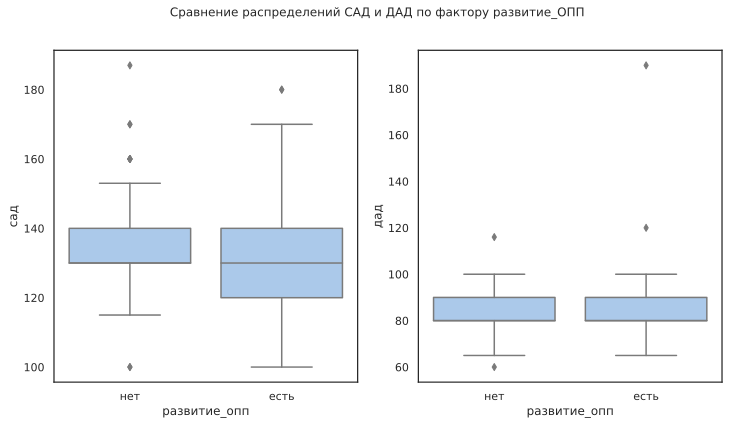

In [959]:
sns.set_color_codes('pastel')
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(data=df, x='развитие_опп', y='сад', color="b", ax=ax[0]);
sns.boxplot(data=df, x='развитие_опп', y='дад', color="b", ax=ax[1]);
plt.suptitle('Сравнение распределений САД и ДАД по фактору развитие_ОПП', size=12)
plt.show()

По имеющимся данным трудно сделать однозначный вывод.

In [960]:
np.round(df.фракция_изгнания.describe(), 3)

count    199.000
mean      59.568
std        9.623
min       33.000
25%       55.000
50%       62.000
75%       66.500
max       81.000
Name: фракция_изгнания, dtype: float64

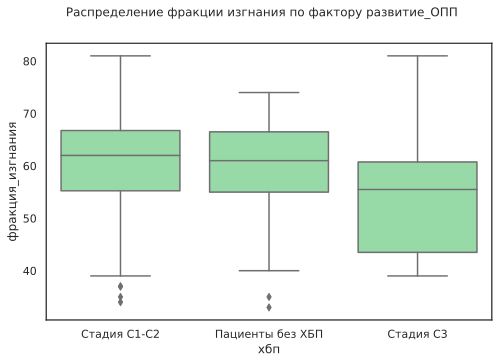

In [961]:
sns.boxplot(data=df, x='хбп', y='фракция_изгнания', color="g");
plt.suptitle('Распределение фракции изгнания по фактору развитие_ОПП', size=12)
plt.show()

Чем ниже фракция изгнания, тем выше риск развития ОПП.

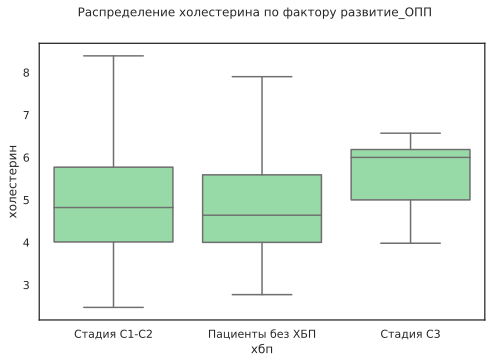

In [962]:
sns.boxplot(data=df[df['есть_ли_пропуски'] == 0], x='хбп', y='холестерин', color="g");
plt.suptitle('Распределение холестерина по фактору развитие_ОПП', size=12)
plt.show()

По графикам видно, что высокий уровень холестерина увеличивает риск развития опп.

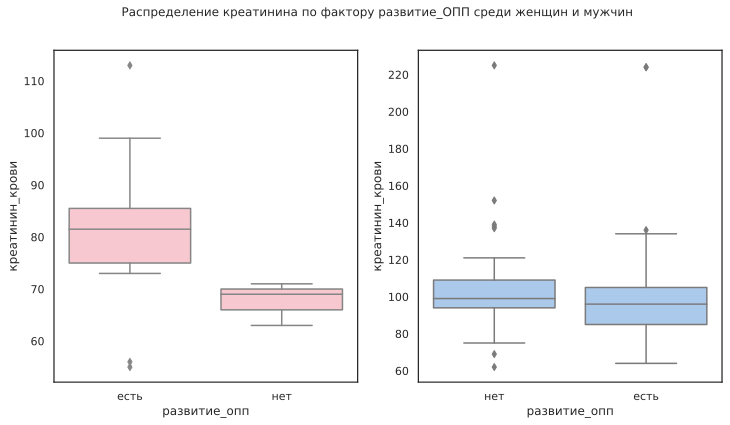

In [963]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(data=df[df['пол'] == 0], x='развитие_опп', y='креатинин_крови', color="pink", ax=ax[0]);
sns.boxplot(data=df[df['пол'] == 1], x='развитие_опп', y='креатинин_крови', color="b", ax=ax[1]);
plt.suptitle('Распределение креатинина по фактору развитие_ОПП среди женщин и мужчин', size=12)
plt.show()

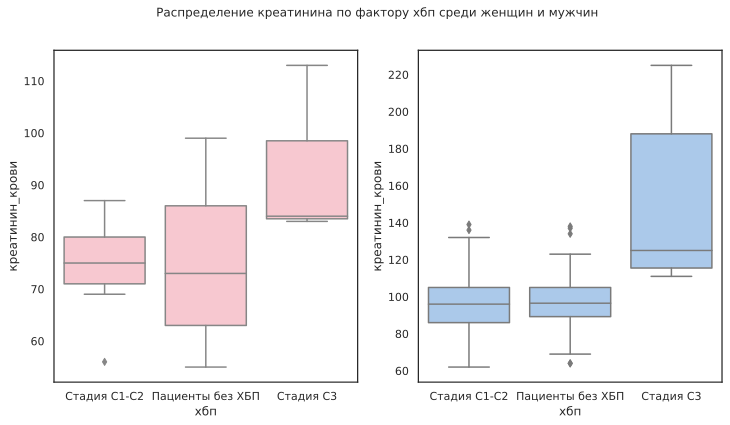

In [964]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(data=df[df['пол'] == 0], x='хбп', y='креатинин_крови', color="pink", ax=ax[0]);
sns.boxplot(data=df[df['пол'] == 1], x='хбп', y='креатинин_крови', color="b", ax=ax[1]);
plt.suptitle('Распределение креатинина по фактору хбп среди женщин и мужчин', size=12)
plt.show()

Действительно, при поражении почек, показатель креатинина в крови будет высоким. Особенно хорошо это заметно на графике по фактору ХБП. 

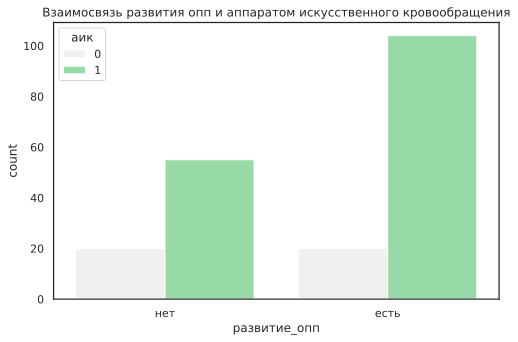

In [965]:
sns.countplot(x='развитие_опп', hue='аик', data=df, color='g')
plt.title('Взаимосвязь развития опп и аппаратом искусственного кровообращения')
plt.show()

Наличие аппарата искусственного кровообращения при проведении операции значительно снижает риск развития опп.

***
### 3. Сформировать дополнительный столбец с данными по пациентам, прооперированным с использованием АИК, которым проводилось переливание крови


In [966]:
df['аик_с_гемотрансфузией'] = 0

df.loc[(df['аик'] == 1) & (df['объем_гемотрансфузии'] > 0), 'аик_с_гемотрансфузией'] = 1 
df.head()

,развитие_опп,хбп,возраст,пол,гб,сахарный_диабет,стенокардия,инфаркт_миокарда,мерцательная_аритмия,желудочковая_экстрасистолия,...,длительность_операции,длительность_аик,время_пережатия_аорты,объем_кровопотерии,объем_гемотрансфузии,объем_инфузий,диурез,есть_ли_пропуски,возрастная_группа,аик_с_гемотрансфузией
0,нет,Стадия C1-C2,67,1,1,1,1,1,0,0,...,150,0,0,200,830,2900,900,0,от 61 до 70,0
1,есть,Стадия C1-C2,69,1,1,0,1,0,0,0,...,235,143,121,600,640,900,800,1,от 61 до 70,1
2,нет,Пациенты без ХБП,50,1,1,0,1,1,0,0,...,210,0,0,250,0,1800,500,1,от 41 до 50,0
3,нет,Стадия C1-C2,62,1,1,0,1,1,1,0,...,210,71,43,500,1283,1700,1700,0,от 61 до 70,1
4,есть,Стадия C1-C2,55,1,1,1,1,1,0,0,...,265,116,74,500,1560,1800,1300,0,от 51 до 60,1


In [967]:
df.head()

,развитие_опп,хбп,возраст,пол,гб,сахарный_диабет,стенокардия,инфаркт_миокарда,мерцательная_аритмия,желудочковая_экстрасистолия,...,длительность_операции,длительность_аик,время_пережатия_аорты,объем_кровопотерии,объем_гемотрансфузии,объем_инфузий,диурез,есть_ли_пропуски,возрастная_группа,аик_с_гемотрансфузией
0,нет,Стадия C1-C2,67,1,1,1,1,1,0,0,...,150,0,0,200,830,2900,900,0,от 61 до 70,0
1,есть,Стадия C1-C2,69,1,1,0,1,0,0,0,...,235,143,121,600,640,900,800,1,от 61 до 70,1
2,нет,Пациенты без ХБП,50,1,1,0,1,1,0,0,...,210,0,0,250,0,1800,500,1,от 41 до 50,0
3,нет,Стадия C1-C2,62,1,1,0,1,1,1,0,...,210,71,43,500,1283,1700,1700,0,от 61 до 70,1
4,есть,Стадия C1-C2,55,1,1,1,1,1,0,0,...,265,116,74,500,1560,1800,1300,0,от 51 до 60,1


Проверим распредение целевого фактора.

***
# II. Расчет, исследование

__Проверить адекватность поставленного диагноза по стадии
хронической болезни почек (найти параметр, по которому
ставится диагноз, использовать данные из внешних источников)__  

- Будем использовать параметр хбп

- Пациентов с скф больше 100 считаем пациентами без хбп

- Пациенты с скф в диапазоне 60-99 относим к 1 и 2 стадиям

- Пациенты с скф в диапазоне 30-59 относим к 3 стадии

- Пациентов с скф 15-29 относим к 4 стадии

- Пациентов с скф меньше 15 относим к 5 стадии

In [968]:
bins = [0, 15, 30, 60, 100, 200]
labels = ["Стадия C5", "Стадия C4", "Стадия С3", "Стадия C1-C2", "Пациенты без ХБП"]

df["хбп_нов"] = pd.cut(df['скф_расч'], bins=bins, labels=labels)

In [969]:
df[df['хбп'] != df['хбп_нов']][['скф_расч', 'хбп', 'хбп_нов']]

,скф_расч,хбп,хбп_нов
5,75.0,Пациенты без ХБП,Стадия C1-C2
7,65.0,Пациенты без ХБП,Стадия C1-C2
12,86.0,Пациенты без ХБП,Стадия C1-C2
13,64.0,Пациенты без ХБП,Стадия C1-C2
19,82.0,Пациенты без ХБП,Стадия C1-C2
...,...,...,...
190,58.0,Пациенты без ХБП,Стадия С3
191,108.0,Стадия C1-C2,Пациенты без ХБП
193,133.0,Стадия C1-C2,Пациенты без ХБП
194,78.0,Пациенты без ХБП,Стадия C1-C2


Почти половина диагнозов выставлена некорректно. Заменяем хбп для дальнейшего использования

In [970]:
df['хбп'] = df['хбп_нов']
df.drop('хбп_нов', axis=1, inplace=True)

__Посчитать процент пациентов с хроническими заболеваниям (сахарный диабет, гипертония, хроническая болезнь почек) для групп “есть ОПП/нет ОПП”__

In [971]:
df2 = pd.concat([df, pd.get_dummies(df['хбп'])], axis=1)

In [972]:
grouped = df2.groupby('развитие_опп')[['сахарный_диабет', 'гб', 'Пациенты без ХБП', 'Стадия C1-C2', 'Стадия С3']].sum()
grouped.iloc[0] /= len(df2[df2['развитие_опп'] == 'есть'])
grouped.iloc[1] /= len(df2[df2['развитие_опп'] == 'нет'])

/tmp/ipykernel_34/893873884.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3467741935483871' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  grouped.iloc[0] /= len(df2[df2['развитие_опп'] == 'есть'])
/tmp/ipykernel_34/893873884.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8709677419354839' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  grouped.iloc[0] /= len(df2[df2['развитие_опп'] == 'есть'])
/tmp/ipykernel_34/893873884.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.24193548387096775' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  grouped.iloc[0] /= len(df2[df2['развитие_опп'] == 'есть'])
/tmp/i

In [973]:
grouped

,сахарный_диабет,гб,Пациенты без ХБП,Стадия C1-C2,Стадия С3
развитие_опп,,,,,
есть,0.346774,0.870968,0.241935,0.629032,0.129032
нет,0.306667,0.906667,0.186667,0.746667,0.066667


__Ввести новый фактор (описать и обосновать выбор фактора и его значений) на основе столбца “Индекс массы тела”.__

Индекс массы тела — величина, позволяющая оценить степень соответствия массы человека и его роста 
и тем самым косвенно судить о том, является ли масса недостаточной, нормальной или избыточной. 
Важен при определении показаний для необходимости лечения. Используем его, чтобы распределить людей в группы по их весу


16 и менее Выраженный дефицит массы тела

16—18,5 Недостаточная (дефицит) масса тела

18,5—25 Норма

25—30 Избыточная масса тела (предожирение)

30—35 Ожирение 1 степени

35—40 Ожирение 2 степени

40 и более Ожирение 3 степени

Выбор фактора обоснован тем, что у людей в разных весовых категориях разное состояние здоровья. Выбор значений обоснован тем, что удобнее всего распределить людей на 3 группы: с пониженным, нормальным и повышенным весом. Граничные значения взяты из интернета

In [974]:
bins = [0, 18.5, 25, 100]
labels = ["Ниже нормы", "Нормальный вес", "Выше нормы"]

df["весовая_категория"] = pd.cut(df["имт"], bins=bins, labels=labels)

In [975]:
df[['имт', 'весовая_категория']]

,имт,весовая_категория
0,30.0,Выше нормы
1,29.0,Выше нормы
2,30.0,Выше нормы
3,30.0,Выше нормы
4,33.0,Выше нормы
...,...,...
195,27.0,Выше нормы
196,29.0,Выше нормы
197,24.0,Нормальный вес
198,33.0,Выше нормы


__Посчитать количество пациентов, имеющих проблемы с
сердцем (выбор перечня проблем должен быть описан и
обоснован) для каждой группы. Сделать вывод.__

О проблемах с сердцем говорят следующий колонки:

Стенокардия - состояние боли в груди из-за недостаточного кровоснабжения сердца

Инфаркт миокарда - гибель части сердечной мышцы

Мерцательная аритмия - нарушение сердечного ритма

Желудочная экстрасистолия - аномальное сердцебиение, которое может привести к остановке сердца

А-в блокада - состояние, при котором электрические импульсы, идущие от предсердий к желудочкам, замедляются или блокируются

Блокада ножек пучка Гиса - нарушение проводимости электрических импульсов в сердце

In [976]:
weight_grouped = df.groupby('весовая_категория')[['стенокардия', 'инфаркт_миокарда',
                                                  'мерцательная_аритмия', 'желудочковая_экстрасистолия',
                                                  'а-в_блокада', 'блокада_ножек_пучка_гиса']].sum() 
                                                  # можно использовать sum так как принимаемые значения это 1 и 0

weight_grouped

/tmp/ipykernel_34/2037697039.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weight_grouped = df.groupby('весовая_категория')[['стенокардия', 'инфаркт_миокарда',


,стенокардия,инфаркт_миокарда,мерцательная_аритмия,желудочковая_экстрасистолия,а-в_блокада,блокада_ножек_пучка_гиса
весовая_категория,,,,,,
Ниже нормы,0,0,0,0,0,0
Нормальный вес,36,28,9,4,1,4
Выше нормы,155,103,41,25,17,28


Вывод: у пациентов с весом выше нормы проблем с сердцем больше, чем у любых других. Однако, в самих записях таких пациентов больше. Для того чтобы учесть это, посчитаем сколько в среднем заболеваний у одного человека для групп с нормальным и повышенным весом. Нужно заметить, что в датасете не было людей с пониженным весом, поэтому мы не можем сделать вывод о этой группе людей

Для нормального веса:

(36 + 28 + 9 + 4 + 1 + 4) / 40 = 2.05 заболевания на человека в среднем

Для повышенного веса: 

(156 + 104 + 42 + 25 + 17 + 28) / 160 = 2.325 заболевания на человека

Можно предположить, что у людей с повышенной массой тела чаще пробелемы с сердцем. Также то, что у нас в датасете людей с повышенной массой тела в 4 раза больше чем здоровых, может указывать на то, что у таких людей чаще возникает опп и/или их чаще оперируют


Давайте также посмотрим на проценты людей с конкретными проблемами в группах

In [977]:
weight_grouped.iloc[1] /= 40
weight_grouped.iloc[2] /= 160

/tmp/ipykernel_34/330856183.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_grouped.iloc[1] /= 40
/tmp/ipykernel_34/330856183.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_grouped.iloc[1] /= 40
/tmp/ipykernel_34/330856183.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.225' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_grouped.iloc[1] /= 40
/tmp/ipykernel_34/330856183.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future ver

In [978]:
weight_grouped

,стенокардия,инфаркт_миокарда,мерцательная_аритмия,желудочковая_экстрасистолия,а-в_блокада,блокада_ножек_пучка_гиса
весовая_категория,,,,,,
Ниже нормы,0.00000,0.00000,0.00000,0.00000,0.00000,0.000
Нормальный вес,0.90000,0.70000,0.22500,0.10000,0.02500,0.100
Выше нормы,0.96875,0.64375,0.25625,0.15625,0.10625,0.175


Люди с весом выше нормы чаще встречаются со стенокардией, мерцательной аритмией, желудочковой экстрасистолией, а-в блокадой и блокадой ножек пучка гиса

In [979]:
df['весовая_категория'].value_counts()

весовая_категория
Выше нормы        159
Нормальный вес     40
Ниже нормы          0
Name: count, dtype: int64

__Исследовать зависимость длительности операции от факта
перенесенного в прошлом инфаркта миокарда__

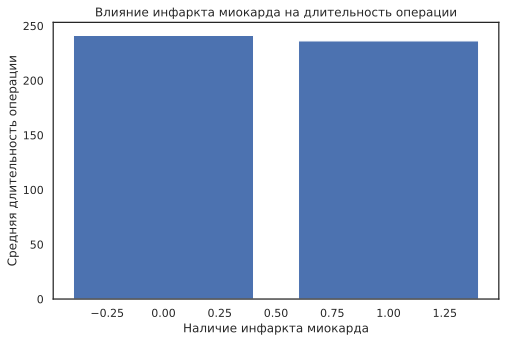

In [980]:
grouped = df.groupby('инфаркт_миокарда')['длительность_операции'].mean()

plt.bar(range(len(grouped)), grouped, align='center')

plt.xlabel('Наличие инфаркта миокарда')
plt.ylabel('Средняя длительность операции')

plt.title('Влияние инфаркта миокарда на длительность операции')

plt.show()

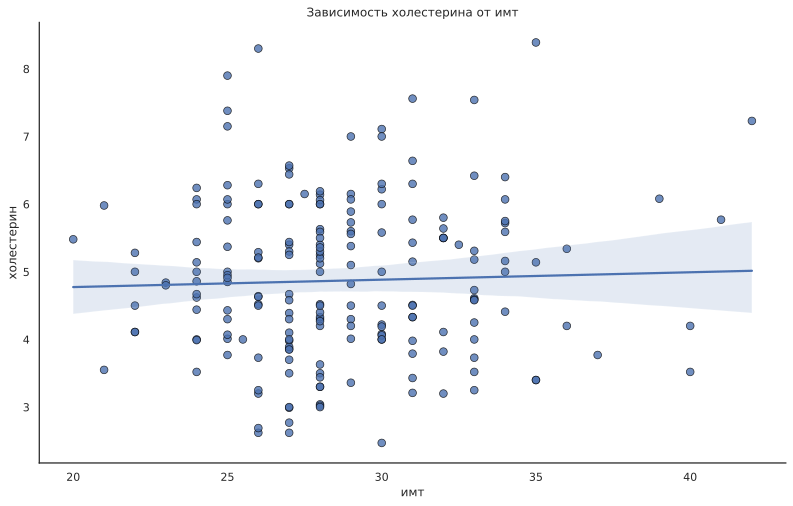

In [981]:
sns.set_style("white")
gridobj = sns.lmplot(x="имт", y="холестерин", data=df, 
                     height=7, aspect=1.6, robust=True, palette='tab10', 
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))

plt.xlabel('имт')
plt.ylabel('холестерин')

plt.title('Зависимость холестерина от имт')

plt.show()

Исходя из наших данных нельзя сказать, что ИМТ влияет на уровень холестерина. Данный вывод не соответствует общеизвестной информации о популяции, скорее всего это обусловлено маленьким датасетом и тем, что мы рассматриваем нездоровых людей

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


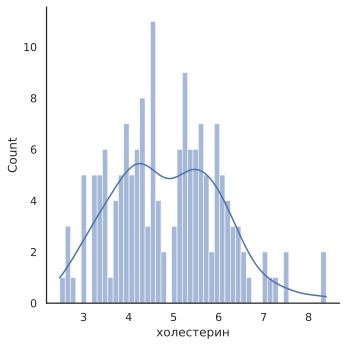

In [982]:
sns.displot(df[df['весовая_категория']=='Выше нормы']['холестерин'], kde=True, bins=50);

/tmp/ipykernel_34/3098691756.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.displot(df[df['весовая_категория']=='Выше нормы'][df['сахарный_диабет']==1]['холестерин'], kde=True, bins=50)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


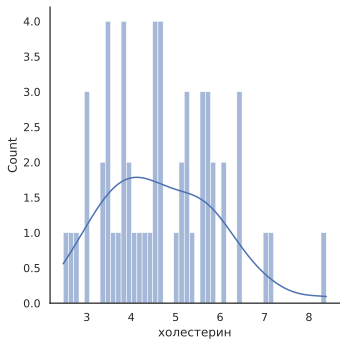

In [983]:
sns.displot(df[df['весовая_категория']=='Выше нормы'][df['сахарный_диабет']==1]['холестерин'], kde=True, bins=50)

/tmp/ipykernel_34/419070255.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.displot(df[df['весовая_категория']=='Выше нормы'][df['сахарный_диабет']==0]['холестерин'], kde=True, bins=50)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


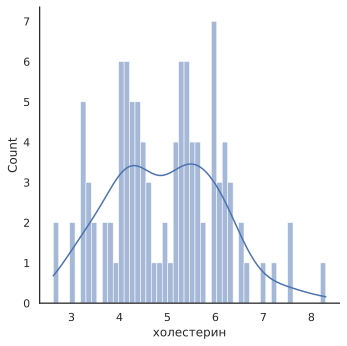

In [984]:
sns.displot(df[df['весовая_категория']=='Выше нормы'][df['сахарный_диабет']==0]['холестерин'], kde=True, bins=50)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


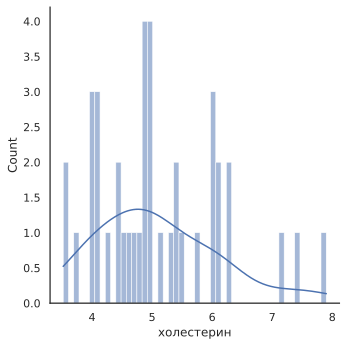

In [985]:
sns.displot(df[df['весовая_категория']=='Нормальный вес']['холестерин'], kde=True, bins=50)

Посмотрев на распределение, заметим что у людей с повышенной массой тела наблюдяются "падение" в районе холестерина равного 5, и есть повышения на значениях 4 и 6. У распределения людей с нормальной массой тела такого не наблюдается. Это интересная особенность данных. 

Мы также посмотрели на распределение людей с повышенной массой тела с сахарным диабетом и без, такое "падение" наблюдается только у людей с сахарным диабетом. 

__Верно ли, что даже без хронических болезней почек с
возрастом толщина паренхимы почек уменьшается?__

In [986]:
df2 = df2[df2['хбп'] == 'Пациенты без ХБП']

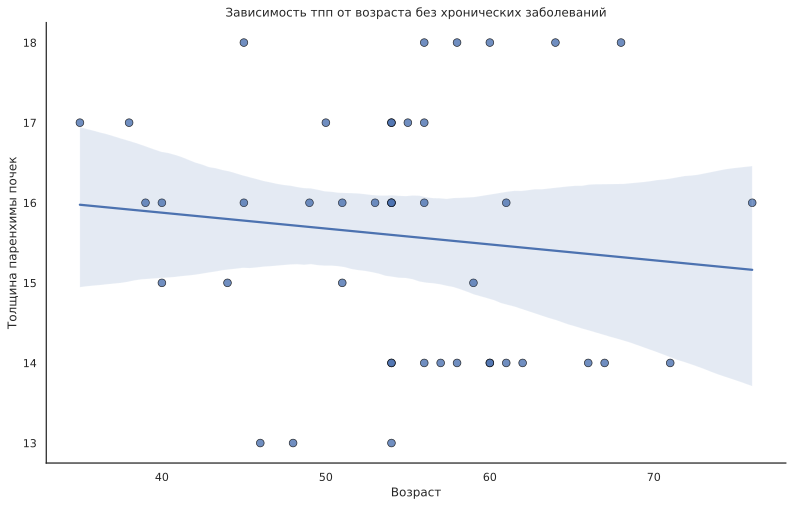

In [987]:
sns.set_style("white")
gridobj = sns.lmplot(x="возраст", y="толщина_паренхимы_почек", data=df2, 
                     height=7, aspect=1.6, robust=True, palette='tab10', 
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))

plt.xlabel('Возраст')
plt.ylabel('Толщина паренхимы почек')

plt.title('Зависимость тпп от возраста без хронических заболеваний')

plt.show()

Да, это верно

## Исследуем корелляцию


In [988]:
df_for_corr = df.copy()

# используем one_hot_encoding

df_for_corr['развитие_опп'] = df_for_corr['развитие_опп'].replace({'есть': 1, 'нет': 0})
df_for_corr = pd.get_dummies(df_for_corr)

/tmp/ipykernel_34/4162074236.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_for_corr['развитие_опп'] = df_for_corr['развитие_опп'].replace({'есть': 1, 'нет': 0})


In [989]:
correlation_matrix = df_for_corr.corr()

threshold = 0.74

# Создаем маску для отбора значений, где абсолютное значение корреляции выше порога
mask = (correlation_matrix.abs() > threshold) & (correlation_matrix != 1)

# Применяем маску к матрице корреляции для исключения строк с низкой корреляцией
correlation_matrix = correlation_matrix.loc[mask.any(axis=1), mask.any(axis=0)]

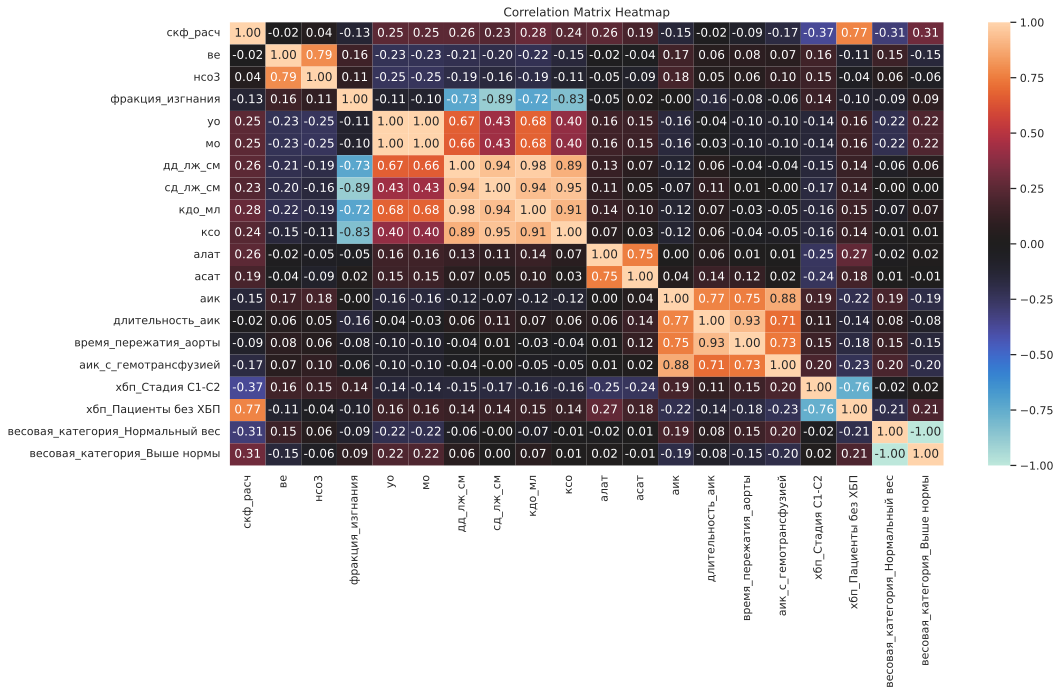

In [990]:
plt.figure(figsize=(16, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='icefire', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

Высокая корелляция наблюдается между:

ве и нсо3

фракцией изгнания и дд_лж_см, сд_лж_см, кдо_мл, ксо

дд_лж_см и сд_лж_см, кдо_мл, ксо

сд_лж_см и кдо_мл, ксо

кдо_мл и ксо

асат и алат

аик и длительность_аик, время_пережатия_аорты, аик_с_гемотрансфузией

длительность аик и время_пережатия_аорты, аик_с_гемотрансфузией

время_пережатия_аорты и аик_с_гемотрансфузией

диагнозами хбп

весовыми категориями

скф_расч и пациенты_без_хбп

Природа корреляции между ве и нсо3 зависит от множества факторов, включая специфическую патологию и общее состояние пациента.

Фракция изгнания (ФИ), которая оценивает, сколько крови выталкивается из сердца за каждое сокращение, может быть связана с параметрами, такими как диаметр левого желудочка в систолу (дд_лж_см) и его систолическая функция (сд_лж_см), которые отражают размер и работу сердца. Также, ФИ может коррелировать с кардиоваскулярным дебитом (КДО_мл) и кардиальным выбросом (КСО), которые оценивают, насколько эффективно сердце перекачивает кровь. Корелляция между всеми этими параметрами объясняется тем, что они описывают работу сердца

Корреляция между уровнями аспартатаминотрансферазы (АСАТ) и аланинаминотрансферазы (АЛАТ) в крови обычно обусловлена их схожими путями метаболизма в организме. Обе эти ферменты активно участвуют в обмене аминокислот

Корелляция между аик-колонками и временем пережатия аорты объясняется тем, что во время работы аик необходимо временно пережать аорту, чтобы хирург мог безопасно работать

Корелляция между диагнозами хбп объясняется тем, что когда 1 диагноз отмечен единицей, все остальные отмечены нулями. Также объясняется корелляция весовых категорий

Корелляция между параметрами аик объясняется очевидно, так как там все колонки так или иначе указывают на факт работы аик, а когда аик не работал, то все они принимают нулевые значения

Корелляция между скф_расч и пациенты_без_хбп объясняется тем, что диагноз ставится основываясь на скф

# III. Выдвижение гипотез







**Анамнез**

Гипотеза 1: С возрастом риск ОПП увеличивается

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


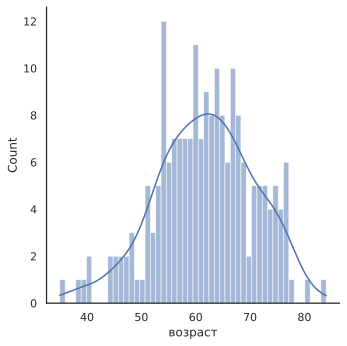

In [991]:
sns.displot(df['возраст'], kde=True, bins=50)

In [992]:
df['развитие_опп_нум'] = df['развитие_опп'].map({'есть': 1, 'нет': 0})

correlation = df['развитие_опп_нум'].corr(df['возраст'])

print("Корелляция между возрастом и фактом развития опп:", correlation)

Корелляция между возрастом и фактом развития опп: 0.0323273383281667


Гипотеза отвергается

Гипотеза 2: наличие диабета увеличивает риск ОПП

In [993]:
correlation = df['развитие_опп_нум'].corr(df['сахарный_диабет'])

print("Корелляция между наличием диабета и фактом развития опп:", correlation)

Корелляция между наличием диабета и фактом развития опп: 0.041282840275553574


Взаимосвязи нет. Гипотеза отвергается

Гипотеза 3: Хронические болезни почек влияют на риск развития ОПП

In [994]:
from scipy.stats import chi2_contingency, pointbiserialr, pearsonr

contingency_table = pd.crosstab(df['развитие_опп_нум'], df['хбп'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

num_obs = np.sum(contingency_table)
phi2 = chi2 / num_obs
r, k = contingency_table.shape
cramers_v = np.sqrt(phi2 / min((k-1), (r-1)))

print('Крамер:', cramers_v)

Крамер: хбп
Стадия С3           0.398121
Стадия C1-C2        0.157606
Пациенты без ХБП    0.275042
dtype: float64


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Наблюдаем взаимосвязь. Гипотезу не отвергаем

**Биохимия**

Гипотеза 1: Высокий уровень холестерина увеличивает риск ОПП

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


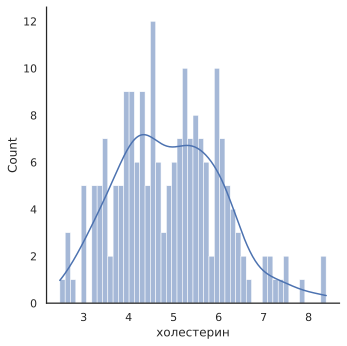

In [995]:
sns.displot(df['холестерин'], kde=True, bins=50)

In [996]:
correlation_coefficient, p_value = pointbiserialr(df['холестерин'], df['развитие_опп_нум'])

print("Коэффициент корелляции бисериальных точек:", correlation_coefficient)
print("p-value:", p_value)

Коэффициент корелляции бисериальных точек: 0.016170924601788903
p-value: 0.820659576566298


Гипотеза отвергается

Гипотеза 2: высокий уровень мочевины увеличивает риск ОПП

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


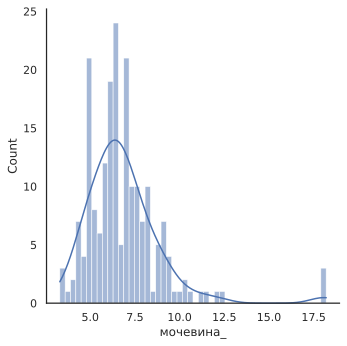

In [997]:
sns.displot(df['мочевина_'], kde=True, bins=50)

In [998]:
correlation_coefficient, p_value = pointbiserialr(df['мочевина_'], df['развитие_опп_нум'])

print("Коэффициент корелляции бисериальных точек:", correlation_coefficient)
print("p-value:", p_value)

Коэффициент корелляции бисериальных точек: -0.026625074975599638
p-value: 0.7089303881182643


Отвергаем гипотезу.

Гипотеза 3: скф влияет на опп

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


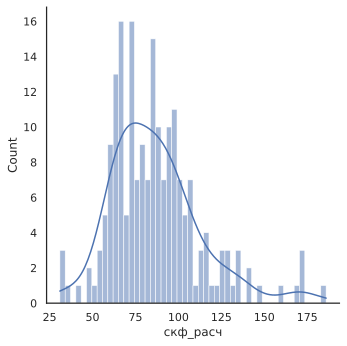

In [999]:
sns.displot(df['скф_расч'], kde=True, bins=50)

In [1000]:
correlation_coefficient, p_value = pointbiserialr(df['скф_расч'], df['развитие_опп_нум'])

print("Коэффициент корелляции бисериальных точек:", correlation_coefficient)
print("p-value:", p_value)

Коэффициент корелляции бисериальных точек: 0.10772016823058918
p-value: 0.1299200686204547


Имеется небольшая связь, возможно она нелинейная. Гипотезу не отвергаем.

Гипотеза 4: оксигемоглобин связан с ОПП

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


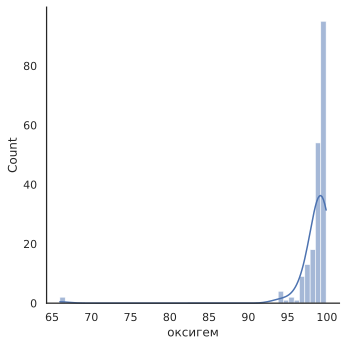

In [1001]:
sns.displot(df['оксигем'], kde=True, bins=50)

In [1002]:
correlation_coefficient, p_value = pointbiserialr(df['оксигем'], df['развитие_опп_нум'])

print("Коэффициент корелляции бисериальных точек:", correlation_coefficient)
print("p-value:", p_value)

Коэффициент корелляции бисериальных точек: -0.07780555224501565
p-value: 0.27469037224330317


Наблюдается слабая связь, не отвергаем гипотезу

Гипотеза 5: калий кореллирует с ОПП

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


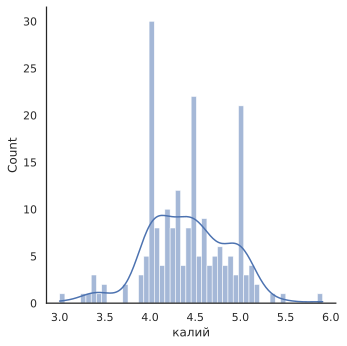

In [1003]:
sns.displot(df['калий'], kde=True, bins=50)

In [1004]:
correlation_coefficient, p_value = pointbiserialr(df['калий'], df['развитие_опп_нум'])

print("Коэффициент корелляции бисериальных точек:", correlation_coefficient)
print("p-value:", p_value)

Коэффициент корелляции бисериальных точек: -0.12048318745960458
p-value: 0.09005684376858407


Связь наблюдается, гипотезу не отвергаем

**Интраоперационные**

Гипотеза 1: Использование АИК повышает риск ОПП

In [1005]:
correlation_coefficient, p_value = pearsonr(df['аик'], df['развитие_опп_нум'])

print("Коэффициент пирсона:", correlation_coefficient)
print("p-value:", p_value)

Коэффициент пирсона: 0.1274254111607308
p-value: 0.0728848454461376


Связь имеется, p-уровень удовлетворительный, давайте посмотрим на корелляцию с длительностью аик

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


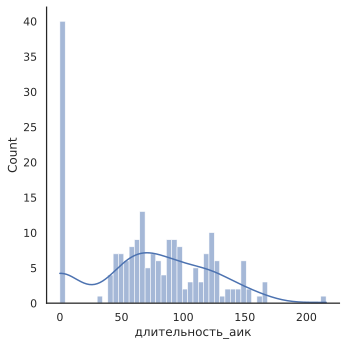

In [1006]:
sns.displot(df['длительность_аик'], kde=True, bins=50)

In [1007]:
correlation_coefficient, p_value = pointbiserialr(df['длительность_аик'], df['развитие_опп_нум'])

print("Коэффициент корелляции бисериальных точек:", correlation_coefficient)
print("p-value:", p_value)

Коэффициент корелляции бисериальных точек: 0.17677787034901354
p-value: 0.012498355247987064


Наблюдается бОльшая корелляция и низкий p-уровень. 

Гипотеза 2: время пережатия аорты кореллирует с развитием ОПП

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


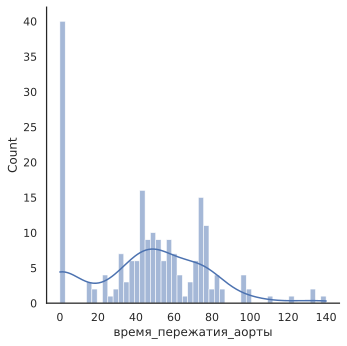

In [1008]:
sns.displot(df['время_пережатия_аорты'], kde=True, bins=50)

In [1009]:
correlation_coefficient, p_value = pointbiserialr(df['время_пережатия_аорты'], df['развитие_опп_нум'])

print("Коэффициент корелляции бисериальных точек:", correlation_coefficient)
print("p-value:", p_value)

Коэффициент корелляции бисериальных точек: 0.16185956171438776
p-value: 0.022371073939148948


Наблюдается корелляция и низкий p-уровень. Отвергаем гипотезу



Гипотеза 3: количество потерянной крови увеличивает риск ОПП

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


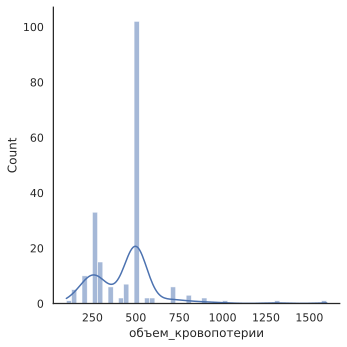

In [1010]:
sns.displot(df['объем_кровопотерии'], kde=True, bins=50)

In [1011]:
correlation_coefficient, p_value = pointbiserialr(df['объем_кровопотерии'], df['развитие_опп_нум'])

print("Коэффициент корелляции бисериальных точек:", correlation_coefficient)
print("p-value:", p_value)

Коэффициент корелляции бисериальных точек: 0.14024285974532583
p-value: 0.04819093237161665


Связь наблюдается, но p-value неудовлетворительный. Гипотезу отвергаем

In [1012]:
df.drop('развитие_опп_нум', axis=1, inplace=True)

Таким образом, мы обнаружили взаимосвязь с:

1) хбп
2) скф
3) оксигемоглобином
4) калием
5) использованием аик
6) временем пережатия аорты

# IV. Регрессионное моделирование

Построим модель, которая будет предсказывать скф у пациента. Для этого используем catboost

In [1013]:
!pip install catboost

In [1014]:
cat = [
    'весовая_категория',
    'хбп',
    'возрастная_группа'
]

In [1015]:
from catboost import CatBoostRegressor, Pool, cv

param_grid = {
    'iterations': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
}

model = CatBoostRegressor(verbose=False)

train_pool = Pool(data=df.drop({'развитие_опп', 'скф_расч'}, axis=1), label=df['скф_расч'], cat_features=cat)

grid_search_result = model.grid_search(param_grid, train_pool, cv=3, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 45.91596451
bestIteration = 99

0:	loss: 45.9159645	best: 45.9159645 (0)	total: 172ms	remaining: 4.47s

bestTest = 12.82509172
bestIteration = 99

1:	loss: 12.8250917	best: 12.8250917 (1)	total: 316ms	remaining: 3.95s

bestTest = 11.39553222
bestIteration = 97

2:	loss: 11.3955322	best: 11.3955322 (2)	total: 460ms	remaining: 3.68s

bestTest = 14.22173366
bestIteration = 499

3:	loss: 14.2217337	best: 11.3955322 (2)	total: 1.28s	remaining: 7.39s

bestTest = 12.18097165
bestIteration = 499

4:	loss: 12.1809717	best: 11.3955322 (2)	total: 2.12s	remaining: 9.31s

bestTest = 12.71370682
bestIteration = 485

5:	loss: 12.7137068	best: 11.3955322 (2)	total: 3.02s	remaining: 10.6s

bestTest = 11.80786457
bestIteration = 996

6:	loss: 11.8078646	best: 11.3955322 (2)	total: 4.69s	remaining: 13.4s

bestTest = 12.01384545
bestIteration = 982

7:	loss: 12.0138455	best: 11.3955322 (2)	total: 6.36s	remaining: 15.1s

bestTest = 12.69856176
bestIteration = 972

8:	loss: 12.6985618	best: 11.3

Посмотрим на важность фичей, то есть на то, чем руководствуется модель при предсказании

In [1016]:
feature_importance = model.get_feature_importance(type="FeatureImportance")

feature_names = df.drop({'развитие_опп', 'скф_расч'}, axis=1).columns

feature_importance_dict = dict(zip(feature_names, feature_importance))

sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: хбп, Importance: 51.422365658652716
Feature: креатинин_крови, Importance: 11.15038482442992
Feature: возраст, Importance: 7.2117183033149725
Feature: имт, Importance: 3.950351252563864
Feature: масса_миокарда_лж, Importance: 3.056969588928462
Feature: кдо_мл, Importance: 1.930080996028907
Feature: оксигем, Importance: 1.3549572887356527
Feature: холестерин, Importance: 1.2367190637346157
Feature: qrs, Importance: 1.0955226488367082
Feature: длительность_операции, Importance: 0.9199806369542322
Feature: натрий, Importance: 0.9084145920420841
Feature: интервал_q-t, Importance: 0.9036799771959481
Feature: фракция_изгнания, Importance: 0.8206904883275017
Feature: общсо2, Importance: 0.7489514899846226
Feature: лпнп, Importance: 0.7446763574264647
Feature: лпонп, Importance: 0.7197124987502898
Feature: дд_лж_см, Importance: 0.7147832157154994
Feature: весовая_категория, Importance: 0.671417357363276
Feature: давл_в_ла, Importance: 0.66776770633677
Feature: асат, Importance: 0.65968

Такое ранжирование фичей правильно, и объясняется тем, что от скф зависит хбп (поэтому это первая по важности фича), а в расчётё скф принимают участие креатинин и возраст (поэтому это вторая и третья по важности фичи соответственно)